
Dataset: breast_cancer_sklearn
Shape: X=(569, 30), y=(569,), Classes=2 -> [0, 1]

Cross-validation (mean±std):
  LogReg                       AUC = 0.9959 ± 0.0050
  SVM_RBF                      AUC = 0.9956 ± 0.0048
  RandomForest                 AUC = 0.9902 ± 0.0073
  GradientBoosting(Fallback)   AUC = 0.9918 ± 0.0052

=== Test Set Evaluation ===

Confusion Matrix (rows=true, cols=pred):
        pred_0  pred_1
true_0      41       1
true_1       1      71

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix (rows=true, cols=pred):
        pred_0  pred_1
true_0      41       1
true_1       1      71

Classification Report:
              precision    recall  f1-score   supp

<Figure size 700x600 with 0 Axes>

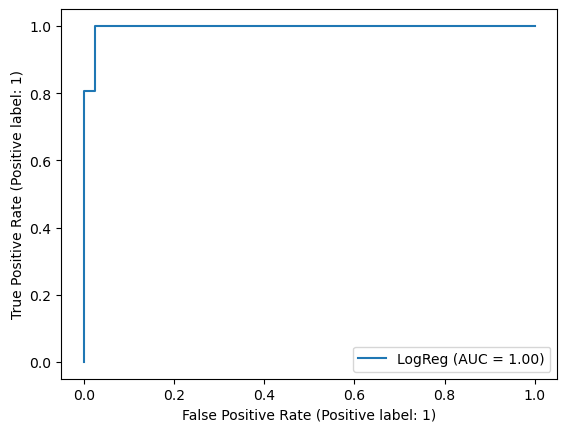

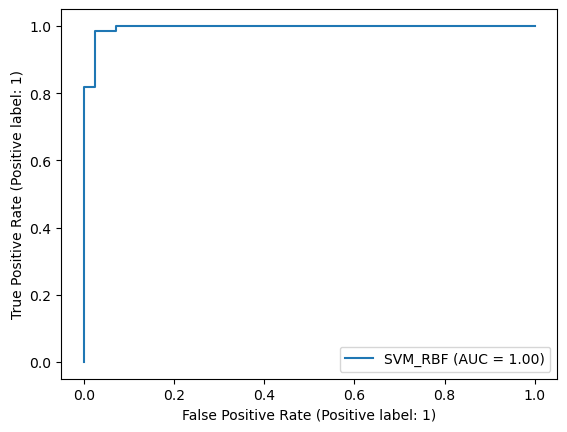

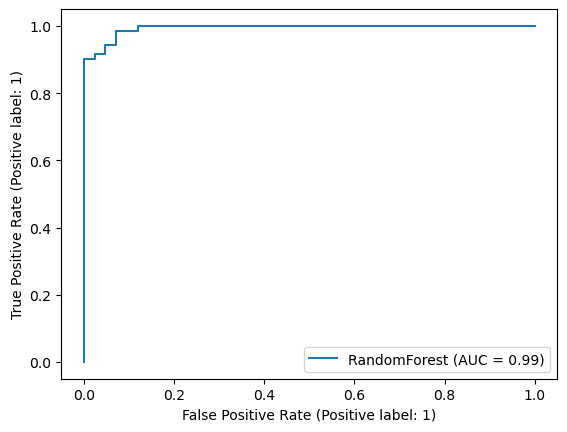

In [1]:
# disease_prediction_pipeline.py
# ---------------------------------------------------------------
# End-to-end disease prediction from medical data
# Models: Logistic Regression, SVM (RBF), Random Forest, XGBoost (optional)
# Features: robust preprocessing, CV, metrics, plots, model saving
# ---------------------------------------------------------------

import argparse
import warnings
warnings.filterwarnings("ignore")

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Try to import XGBoost; if unavailable, we'll fall back gracefully.
HAS_XGB = True
try:
    from xgboost import XGBClassifier
except Exception:
    HAS_XGB = False

# ----------------------------
# Helpers
# ----------------------------
def load_data_from_args(args):
    """
    Returns X (DataFrame), y (Series), dataset_name (str).
    If args.csv is None, load sklearn Breast Cancer dataset.
    """
    if args.csv is None:
        data = load_breast_cancer(as_frame=True)
        df = data.frame.copy()
        target_col = data.target.name
        y = df[target_col]
        X = df.drop(columns=[target_col])
        dataset_name = "breast_cancer_sklearn"
        return X, y, dataset_name
    else:
        if not os.path.exists(args.csv):
            raise FileNotFoundError(f"CSV not found: {args.csv}")
        df = pd.read_csv(args.csv)
        if args.target is None:
            raise ValueError("Please provide --target when using --csv.")
        if args.target not in df.columns:
            raise ValueError(f"Target column '{args.target}' not found in CSV.")
        y = df[args.target]
        X = df.drop(columns=[args.target])
        dataset_name = os.path.splitext(os.path.basename(args.csv))[0]
        return X, y, dataset_name

def build_preprocessor(X: pd.DataFrame):
    """
    Detect column types and build a ColumnTransformer with:
      - numeric: median impute + standard scale
      - categorical: most_frequent impute + one-hot encode (ignore unknowns)
    """
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ],
        remainder="drop"
    )
    return preprocessor, numeric_cols, categorical_cols

def build_models(random_state=42):
    """
    Return dict of model_name -> estimator (without preprocessing).
    """
    models = {
        "LogReg": LogisticRegression(max_iter=1000, n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
        "SVM_RBF": SVC(kernel="rbf", probability=True),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=random_state)
    }
    if HAS_XGB:
        models["XGBoost"] = XGBClassifier(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=random_state,
            eval_metric="logloss",
            tree_method="auto"
        )
    else:
        models["GradientBoosting(Fallback)"] = GradientBoostingClassifier(random_state=random_state)
    return models

def cv_scores(model, X, y, cv_splits=5, scoring="roc_auc"):
    """
    Compute cross-val scores with StratifiedKFold. Works for binary or multiclass.
    For multiclass, use 'ovr' ROC-AUC.
    """
    if len(np.unique(y)) > 2 and scoring == "roc_auc":
        scoring = "roc_auc_ovr"
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=None)
    return float(np.mean(scores)), float(np.std(scores))

def evaluate(model, X_test, y_test, labels):
    """
    Return dict of metrics and show confusion matrix & classification report.
    """
    y_pred = model.predict(X_test)
    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision_weighted": float(precision_score(y_test, y_pred, average="weighted", zero_division=0)),
        "recall_weighted": float(recall_score(y_test, y_pred, average="weighted", zero_division=0)),
        "f1_weighted": float(f1_score(y_test, y_pred, average="weighted", zero_division=0)),
    }
    # ROC-AUC
    try:
        y_proba = model.predict_proba(X_test)
        if len(labels) > 2:
            metrics["roc_auc_ovr"] = float(roc_auc_score(y_test, y_proba, multi_class="ovr"))
        else:
            metrics["roc_auc"] = float(roc_auc_score(y_test, y_proba[:, 1]))
    except Exception:
        pass

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels]))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    return metrics

def plot_roc_curves(models_fitted, X_test, y_test, labels, out_dir):
    """
    Plot ROC curves for all models (binary or multiclass One-vs-Rest).
    """
    os.makedirs(out_dir, exist_ok=True)

    # For binary case, plot a single curve per model.
    if len(labels) == 2:
        plt.figure(figsize=(7, 6))
        for name, model in models_fitted.items():
            try:
                RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
            except Exception:
                continue
        plt.title("ROC Curves (Binary)")
        plt.savefig(os.path.join(out_dir, "roc_curves.png"), bbox_inches="tight", dpi=150)
        plt.close()
        return

    # For multiclass, plot One-vs-Rest curves per model (micro-average)
    for name, model in models_fitted.items():
        try:
            plt.figure(figsize=(7, 6))
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
            plt.title(f"ROC Curve (Multiclass OVR) – {name}")
            plt.savefig(os.path.join(out_dir, f"roc_curve_{name}.png"), bbox_inches="tight", dpi=150)
            plt.close()
        except Exception:
            continue

def extract_feature_names(preprocessor, numeric_cols, categorical_cols):
    """
    Get the transformed feature names after ColumnTransformer (numeric + one-hot categorical).
    """
    out_names = []

    # numeric pipeline features
    out_names.extend(numeric_cols)

    # categorical pipeline features (one-hot)
    if len(categorical_cols) > 0:
        ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
        cat_ohe_names = list(ohe.get_feature_names_out(categorical_cols))
        out_names.extend(cat_ohe_names)

    return out_names

def show_feature_importance(model, feature_names, top_k=15):
    """
    Print top feature importances for tree-based models or coefficients for Logistic Regression.
    """
    print("\n--- Top Features ---")
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:top_k]
        for i in idx:
            print(f"{feature_names[i]:40s}  {importances[i]:.4f}")
    elif hasattr(model, "coef_"):
        coefs = np.ravel(model.coef_) if model.coef_.ndim == 2 else model.coef_
        idx = np.argsort(np.abs(coefs))[::-1][:top_k]
        for i in idx:
            print(f"{feature_names[i]:40s}  {coefs[i]:.4f}")
    else:
        print("Feature importance not available for this model type.")

# ----------------------------
# Main
# ----------------------------
def main():
    parser = argparse.ArgumentParser(description="Disease Prediction from Medical Data")
    parser.add_argument("--csv", type=str, default=None,
                        help="Path to your dataset CSV. If omitted, uses sklearn breast cancer dataset.")
    parser.add_argument("--target", type=str, default=None,
                        help="Target column name (required when using --csv).")
    parser.add_argument("--test_size", type=float, default=0.2)
    parser.add_argument("--cv", type=int, default=5, help="StratifiedKFold splits for CV.")
    parser.add_argument("--out", type=str, default="outputs", help="Directory to save artifacts.")
    args = parser.parse_args([])  # Safe default for copy-paste in notebooks; replace with '()' for CLI.

    # Load data
    X, y, dataset_name = load_data_from_args(args)
    labels = sorted(pd.unique(y))
    print(f"\nDataset: {dataset_name}")
    print(f"Shape: X={X.shape}, y={y.shape}, Classes={len(labels)} -> {labels}")

    # Preprocessor
    preprocessor, num_cols, cat_cols = build_preprocessor(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=args.test_size, stratify=y, random_state=42
    )

    # Build models and pipelines
    raw_models = build_models(random_state=42)
    pipelines = {
        name: Pipeline(steps=[("prep", preprocessor), ("clf", model)])
        for name, model in raw_models.items()
    }

    # Cross-validation (ROC-AUC) and fit
    results = {}
    print("\nCross-validation (mean±std):")
    for name, pipe in pipelines.items():
        mean_auc, std_auc = cv_scores(pipe, X_train, y_train, cv_splits=args.cv, scoring="roc_auc")
        results[name] = {"cv_roc_auc_mean": mean_auc, "cv_roc_auc_std": std_auc}
        print(f"  {name:28s} AUC = {mean_auc:.4f} ± {std_auc:.4f}")

    # Fit all, evaluate on test
    fitted = {}
    print("\n=== Test Set Evaluation ===")
    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        fitted[name] = pipe
        metrics = evaluate(pipe, X_test, y_test, labels)
        results[name].update(metrics)

    # Decide best by ROC-AUC (binary) or F1 (multiclass) on test
    if len(labels) == 2:
        key = "roc_auc"
    else:
        key = "f1_weighted"
    # Fallback if key missing
    for name in results:
        if key not in results[name]:
            results[name][key] = results[name].get("roc_auc_ovr", -1.0)

    best_model_name = max(results, key=lambda k: results[k][key])
    best_model = fitted[best_model_name]
    print(f"\nBest model by test {key}: {best_model_name}")

    # Save artifacts
    os.makedirs(args.out, exist_ok=True)
    model_path = os.path.join(args.out, f"{dataset_name}_{best_model_name}.joblib")
    joblib.dump(best_model, model_path)

    # Save metrics
    with open(os.path.join(args.out, f"{dataset_name}_metrics.json"), "w") as f:
        json.dump(results, f, indent=2)

    # ROC curves
    plot_roc_curves(fitted, X_test, y_test, labels, args.out)

    # Feature names & importance for best model
    # We need the fitted preprocessor to extract final feature names.
    prep_fitted = best_model.named_steps["prep"]
    feat_names = extract_feature_names(prep_fitted, num_cols, cat_cols)
    print(f"\nSaved best model to: {model_path}")
    print(f"All metrics JSON: {os.path.join(args.out, f'{dataset_name}_metrics.json')}")
    print(f"ROC plots saved in: {args.out}")

    # Show feature importance for best estimator (post-preprocessing)
    clf = best_model.named_steps["clf"]
    show_feature_importance(clf, feat_names, top_k=15)

    # Pretty-print metrics summary
    print("\n=== Summary (key metrics) ===")
    summary_cols = ["cv_roc_auc_mean", "accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]
    # pick roc key
    if len(labels) == 2:
        summary_cols.append("roc_auc")
    else:
        summary_cols.append("roc_auc_ovr")

    df_summary = pd.DataFrame(results).T[summary_cols]
    print(df_summary.sort_values(by=summary_cols[-1], ascending=False).round(4))

if __name__ == "__main__":
    main()
